In [1]:
import os
import sys
import random
import warnings

import cv2
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imsave, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
# Import
from keras.models import Model
from keras.layers import Input, Conv2D,Conv2DTranspose, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Activation, add
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.losses import binary_crossentropy

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from keras import backend as K
import tensorflow as tf

import Image_preprocess
import U_net_model


Using TensorFlow backend.


In [2]:
train = '../data/train'
val = '../data/valid'
output = './Models/'
epochs = 200
batch_size = 2


def cfg_from_file(filename):
  """Load a config file and merge it into the default options."""
  import yaml
  with open(filename, 'r') as f:
    yaml_cfg = yaml.load(f)
  return yaml_cfg

cfg_file = "cfgs/cfg.yml"
unet_cfg = cfg_from_file(cfg_file)

In [3]:
K.set_image_data_format('channels_last')     # TF dimension ordering in this code
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
SEED = unet_cfg['SEED']
Raw_channels= unet_cfg['Raw_channels']
image_rows = unet_cfg['image_rows']
image_cols = unet_cfg['image_cols']
image_channels = unet_cfg['image_channels']
k = unet_cfg['k']
num_classes=unet_cfg['num_classes']
threshold= unet_cfg['threshold']
ratio = unet_cfg['ratio']

In [4]:
#### Define a combined data generator
#### function to combine generators (https://github.com/keras-team/keras/issues/5720)
def combine_generator(gen1, gen2):
    while True:                                                       ### BE SURE TO add 'True' to make it a loop 
        yield(gen1.next(), gen2.next())

In [5]:
###Load and Prepocess Images

train_imgs_path   =     os.path.join(train,'Images/')
train_masks_path  =     os.path.join(train,'Masks')
#pred_path        =     './PredMasks/2'
val_imgs_path     =     os.path.join(val,'Images/')
val_masks_path    =     os.path.join(val,'Masks')

train_imgs_array, train_masks_array, sizes_val = Image_preprocess.load_img_masks(train_imgs_path, train_masks_path, folder = str(1))
mean = np.mean(train_imgs_array.astype('float32'))
std  = np.std(train_imgs_array.astype('float32'))

if os.path.exists(val):
    val_imgs_array, val_masks_array, sizes_val = Image_preprocess.load_img_masks(val_imgs_path, val_masks_path, folder = str(1) )

else: 
    
    val_imgs_array = train_imgs_array[int(ratio*len(train_imgs_array)):]
    val_masks_array = train_masks_array[int(ratio*len(train_masks_array)):]
    
    train_imgs_array = train_imgs_array[:int(ratio*len(train_imgs_array))]
    train_masks_array = train_masks_array[:int(ratio*len(train_masks_array))]

loading... testing dataset


D:\ProgramData\Anaconda3\envs\py3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Done: 0/131 images
Done: 5/131 images
Done: 10/131 images
Done: 15/131 images
Done: 20/131 images
Done: 25/131 images
Done: 30/131 images
Done: 35/131 images
Done: 40/131 images
Done: 45/131 images
Done: 50/131 images
Done: 55/131 images
Done: 60/131 images
Done: 65/131 images
Done: 70/131 images
Done: 75/131 images
Done: 80/131 images
Done: 85/131 images
Done: 90/131 images
Done: 95/131 images
Done: 100/131 images
Done: 105/131 images
Done: 110/131 images
Done: 115/131 images
Done: 120/131 images
Done: 125/131 images
Done: 130/131 images
loading... testing dataset
Done: 0/90 images
Done: 5/90 images
Done: 10/90 images
Done: 15/90 images
Done: 20/90 images
Done: 25/90 images
Done: 30/90 images
Done: 35/90 images
Done: 40/90 images
Done: 45/90 images
Done: 50/90 images
Done: 55/90 images
Done: 60/90 images
Done: 65/90 images
Done: 70/90 images
Done: 75/90 images
Done: 80/90 images
Done: 85/90 images


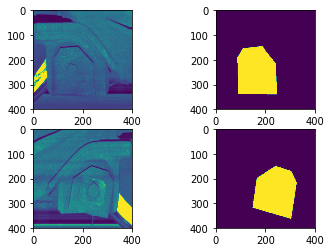

In [6]:
###Sample Images
fig = plt.figure()
plt.subplot(221)
plt.imshow(train_imgs_array[0,:,:,0])
plt.subplot(222)
plt.imshow(train_masks_array[0,:,:,0])
plt.subplot(223)
plt.imshow(train_imgs_array[15,:,:,0])
plt.subplot(224)
plt.imshow(train_masks_array[15,:,:,0])
plt.show()

In [7]:
model = U_net_model.UnetResidual_model(input_shape=(image_rows,image_cols,image_channels),num_classes=1,  k=k)
#### checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=15)
model_checkpoint = ModelCheckpoint(os.path.join(output,'unetRes_plate_{}x{}_k{}.h5'.format(image_rows,image_cols,k)),\
                                   monitor="val_loss", save_best_only=True, save_weights_only=False, verbose=1)  
if os.path.exists(os.path.join(output,'unetRes_plate_{}x{}_k{}.h5'.format(image_rows,image_cols,k))):
    model.load_weights(os.path.join(output,'unetRes_plate_{}x{}_k{}.h5'.format(image_rows,image_cols,k)))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400, 400, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 400, 400, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 400, 400, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 400, 400, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

dropout_1 (Dropout)             (None, 25, 25, 128)  0           max_pooling2d_4[0][0]            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 25, 25, 256)  295168      dropout_1[0][0]                  
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 25, 25, 256)  1024        conv2d_12[0][0]                  
__________________________________________________________________________________________________
activation_9 (Activation)       (None, 25, 25, 256)  0           batch_normalization_12[0][0]     
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 25, 25, 256)  590080      activation_9[0][0]               
__________________________________________________________________________________________________
conv2d_14 

__________________________________________________________________________________________________
up_sampling2d_3 (UpSampling2D)  (None, 200, 200, 64) 0           activation_16[0][0]              
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 200, 200, 96) 0           activation_4[0][0]               
                                                                 up_sampling2d_3[0][0]            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 200, 200, 32) 27680       concatenate_3[0][0]              
__________________________________________________________________________________________________
batch_normalization_23 (BatchNo (None, 200, 200, 32) 128         conv2d_23[0][0]                  
__________________________________________________________________________________________________
activation

In [9]:
model.fit_generator(Image_preprocess.train_generator(train_imgs_array,train_masks_array,batch_size),
                    steps_per_epoch=len(train_imgs_array) // batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True,
                    validation_data = Image_preprocess.val_generator(val_imgs_array,val_masks_array,batch_size),
                    validation_steps= val_imgs_array.shape[0] // batch_size,
                    callbacks=[early_stopping,model_checkpoint])

Epoch 1/200
52/52 [==============================] - ETA: 5:07 - loss: 0.1775 - dice_coeff: 0.64 - ETA: 2:34 - loss: 0.1171 - dice_coeff: 0.73 - ETA: 1:42 - loss: 0.0999 - dice_coeff: 0.75 - ETA: 1:16 - loss: 0.0809 - dice_coeff: 0.78 - ETA: 1:01 - loss: 0.0790 - dice_coeff: 0.79 - ETA: 51s - loss: 0.0720 - dice_coeff: 0.8007 - ETA: 43s - loss: 0.0716 - dice_coeff: 0.793 - ETA: 37s - loss: 0.0659 - dice_coeff: 0.803 - ETA: 33s - loss: 0.0646 - dice_coeff: 0.804 - ETA: 30s - loss: 0.0728 - dice_coeff: 0.791 - ETA: 27s - loss: 0.0839 - dice_coeff: 0.775 - ETA: 24s - loss: 0.0813 - dice_coeff: 0.778 - ETA: 22s - loss: 0.0778 - dice_coeff: 0.785 - ETA: 20s - loss: 0.0769 - dice_coeff: 0.786 - ETA: 19s - loss: 0.0763 - dice_coeff: 0.784 - ETA: 17s - loss: 0.0760 - dice_coeff: 0.783 - ETA: 16s - loss: 0.0748 - dice_coeff: 0.784 - ETA: 15s - loss: 0.0736 - dice_coeff: 0.786 - ETA: 14s - loss: 0.0718 - dice_coeff: 0.789 - ETA: 13s - loss: 0.0696 - dice_coeff: 0.794 - ETA: 12s - loss: 0.0683 - 

52/52 [==============================] - ETA: 6s - loss: 0.0379 - dice_coeff: 0.85 - ETA: 6s - loss: 0.0386 - dice_coeff: 0.83 - ETA: 5s - loss: 0.0364 - dice_coeff: 0.84 - ETA: 5s - loss: 0.0554 - dice_coeff: 0.80 - ETA: 5s - loss: 0.0548 - dice_coeff: 0.79 - ETA: 5s - loss: 0.0516 - dice_coeff: 0.80 - ETA: 5s - loss: 0.0489 - dice_coeff: 0.81 - ETA: 5s - loss: 0.0472 - dice_coeff: 0.81 - ETA: 5s - loss: 0.0479 - dice_coeff: 0.82 - ETA: 5s - loss: 0.0497 - dice_coeff: 0.81 - ETA: 4s - loss: 0.0516 - dice_coeff: 0.82 - ETA: 4s - loss: 0.0496 - dice_coeff: 0.82 - ETA: 4s - loss: 0.0488 - dice_coeff: 0.82 - ETA: 4s - loss: 0.0513 - dice_coeff: 0.82 - ETA: 4s - loss: 0.0535 - dice_coeff: 0.82 - ETA: 4s - loss: 0.0532 - dice_coeff: 0.82 - ETA: 4s - loss: 0.0522 - dice_coeff: 0.82 - ETA: 4s - loss: 0.0514 - dice_coeff: 0.82 - ETA: 4s - loss: 0.0513 - dice_coeff: 0.82 - ETA: 3s - loss: 0.0515 - dice_coeff: 0.82 - ETA: 3s - loss: 0.0522 - dice_coeff: 0.82 - ETA: 3s - loss: 0.0523 - dice_coeff

52/52 [==============================] - ETA: 6s - loss: 0.0281 - dice_coeff: 0.89 - ETA: 6s - loss: 0.0255 - dice_coeff: 0.89 - ETA: 5s - loss: 0.0284 - dice_coeff: 0.89 - ETA: 5s - loss: 0.0278 - dice_coeff: 0.89 - ETA: 5s - loss: 0.0290 - dice_coeff: 0.89 - ETA: 5s - loss: 0.0282 - dice_coeff: 0.89 - ETA: 5s - loss: 0.0283 - dice_coeff: 0.89 - ETA: 5s - loss: 0.0291 - dice_coeff: 0.89 - ETA: 5s - loss: 0.0514 - dice_coeff: 0.86 - ETA: 5s - loss: 0.0489 - dice_coeff: 0.86 - ETA: 5s - loss: 0.0480 - dice_coeff: 0.86 - ETA: 4s - loss: 0.0463 - dice_coeff: 0.86 - ETA: 4s - loss: 0.0462 - dice_coeff: 0.86 - ETA: 4s - loss: 0.0453 - dice_coeff: 0.86 - ETA: 4s - loss: 0.0450 - dice_coeff: 0.87 - ETA: 4s - loss: 0.0451 - dice_coeff: 0.87 - ETA: 4s - loss: 0.0462 - dice_coeff: 0.86 - ETA: 4s - loss: 0.0457 - dice_coeff: 0.86 - ETA: 4s - loss: 0.0464 - dice_coeff: 0.86 - ETA: 3s - loss: 0.0451 - dice_coeff: 0.86 - ETA: 3s - loss: 0.0440 - dice_coeff: 0.86 - ETA: 3s - loss: 0.0436 - dice_coeff

52/52 [==============================] - ETA: 6s - loss: 0.0421 - dice_coeff: 0.87 - ETA: 5s - loss: 0.0485 - dice_coeff: 0.84 - ETA: 5s - loss: 0.0421 - dice_coeff: 0.86 - ETA: 5s - loss: 0.0369 - dice_coeff: 0.87 - ETA: 5s - loss: 0.0413 - dice_coeff: 0.86 - ETA: 5s - loss: 0.0397 - dice_coeff: 0.86 - ETA: 5s - loss: 0.0369 - dice_coeff: 0.87 - ETA: 5s - loss: 0.0373 - dice_coeff: 0.87 - ETA: 5s - loss: 0.0355 - dice_coeff: 0.87 - ETA: 5s - loss: 0.0346 - dice_coeff: 0.88 - ETA: 5s - loss: 0.0339 - dice_coeff: 0.88 - ETA: 4s - loss: 0.0335 - dice_coeff: 0.88 - ETA: 4s - loss: 0.0338 - dice_coeff: 0.88 - ETA: 4s - loss: 0.0341 - dice_coeff: 0.88 - ETA: 4s - loss: 0.0335 - dice_coeff: 0.88 - ETA: 4s - loss: 0.0345 - dice_coeff: 0.88 - ETA: 4s - loss: 0.0355 - dice_coeff: 0.88 - ETA: 4s - loss: 0.0347 - dice_coeff: 0.88 - ETA: 4s - loss: 0.0344 - dice_coeff: 0.88 - ETA: 3s - loss: 0.0345 - dice_coeff: 0.88 - ETA: 3s - loss: 0.0341 - dice_coeff: 0.88 - ETA: 3s - loss: 0.0338 - dice_coeff

52/52 [==============================] - ETA: 6s - loss: 0.0376 - dice_coeff: 0.87 - ETA: 6s - loss: 0.0372 - dice_coeff: 0.87 - ETA: 5s - loss: 0.0384 - dice_coeff: 0.86 - ETA: 5s - loss: 0.0400 - dice_coeff: 0.86 - ETA: 5s - loss: 0.0417 - dice_coeff: 0.85 - ETA: 5s - loss: 0.0394 - dice_coeff: 0.86 - ETA: 5s - loss: 0.0362 - dice_coeff: 0.87 - ETA: 5s - loss: 0.0347 - dice_coeff: 0.87 - ETA: 5s - loss: 0.0345 - dice_coeff: 0.87 - ETA: 5s - loss: 0.0335 - dice_coeff: 0.87 - ETA: 5s - loss: 0.0326 - dice_coeff: 0.88 - ETA: 4s - loss: 0.0335 - dice_coeff: 0.87 - ETA: 4s - loss: 0.0361 - dice_coeff: 0.87 - ETA: 4s - loss: 0.0355 - dice_coeff: 0.87 - ETA: 4s - loss: 0.0344 - dice_coeff: 0.87 - ETA: 4s - loss: 0.0355 - dice_coeff: 0.87 - ETA: 4s - loss: 0.0349 - dice_coeff: 0.88 - ETA: 4s - loss: 0.0343 - dice_coeff: 0.88 - ETA: 4s - loss: 0.0360 - dice_coeff: 0.87 - ETA: 3s - loss: 0.0355 - dice_coeff: 0.87 - ETA: 3s - loss: 0.0347 - dice_coeff: 0.88 - ETA: 3s - loss: 0.0348 - dice_coeff

52/52 [==============================] - ETA: 6s - loss: 0.0203 - dice_coeff: 0.91 - ETA: 6s - loss: 0.0241 - dice_coeff: 0.90 - ETA: 5s - loss: 0.0277 - dice_coeff: 0.90 - ETA: 5s - loss: 0.0280 - dice_coeff: 0.90 - ETA: 5s - loss: 0.0257 - dice_coeff: 0.91 - ETA: 5s - loss: 0.0255 - dice_coeff: 0.91 - ETA: 5s - loss: 0.0256 - dice_coeff: 0.91 - ETA: 5s - loss: 0.0292 - dice_coeff: 0.90 - ETA: 5s - loss: 0.0315 - dice_coeff: 0.89 - ETA: 5s - loss: 0.0308 - dice_coeff: 0.89 - ETA: 5s - loss: 0.0299 - dice_coeff: 0.90 - ETA: 4s - loss: 0.0288 - dice_coeff: 0.90 - ETA: 4s - loss: 0.0325 - dice_coeff: 0.89 - ETA: 4s - loss: 0.0321 - dice_coeff: 0.89 - ETA: 4s - loss: 0.0315 - dice_coeff: 0.89 - ETA: 4s - loss: 0.0306 - dice_coeff: 0.89 - ETA: 4s - loss: 0.0300 - dice_coeff: 0.90 - ETA: 4s - loss: 0.0310 - dice_coeff: 0.89 - ETA: 4s - loss: 0.0310 - dice_coeff: 0.89 - ETA: 3s - loss: 0.0308 - dice_coeff: 0.89 - ETA: 3s - loss: 0.0305 - dice_coeff: 0.89 - ETA: 3s - loss: 0.0305 - dice_coeff

52/52 [==============================] - ETA: 6s - loss: 0.0325 - dice_coeff: 0.88 - ETA: 5s - loss: 0.0501 - dice_coeff: 0.85 - ETA: 5s - loss: 0.0457 - dice_coeff: 0.85 - ETA: 5s - loss: 0.0405 - dice_coeff: 0.87 - ETA: 5s - loss: 0.0436 - dice_coeff: 0.85 - ETA: 5s - loss: 0.0447 - dice_coeff: 0.85 - ETA: 5s - loss: 0.0424 - dice_coeff: 0.86 - ETA: 5s - loss: 0.0417 - dice_coeff: 0.86 - ETA: 5s - loss: 0.0437 - dice_coeff: 0.85 - ETA: 5s - loss: 0.0451 - dice_coeff: 0.85 - ETA: 4s - loss: 0.0441 - dice_coeff: 0.85 - ETA: 4s - loss: 0.0431 - dice_coeff: 0.85 - ETA: 4s - loss: 0.0417 - dice_coeff: 0.86 - ETA: 4s - loss: 0.0415 - dice_coeff: 0.86 - ETA: 4s - loss: 0.0414 - dice_coeff: 0.86 - ETA: 4s - loss: 0.0414 - dice_coeff: 0.86 - ETA: 4s - loss: 0.0404 - dice_coeff: 0.86 - ETA: 4s - loss: 0.0401 - dice_coeff: 0.86 - ETA: 4s - loss: 0.0409 - dice_coeff: 0.86 - ETA: 3s - loss: 0.0408 - dice_coeff: 0.86 - ETA: 3s - loss: 0.0400 - dice_coeff: 0.86 - ETA: 3s - loss: 0.0394 - dice_coeff

52/52 [==============================] - ETA: 6s - loss: 0.0514 - dice_coeff: 0.86 - ETA: 6s - loss: 0.3253 - dice_coeff: 0.67 - ETA: 5s - loss: 0.2261 - dice_coeff: 0.75 - ETA: 5s - loss: 0.1778 - dice_coeff: 0.78 - ETA: 5s - loss: 0.1501 - dice_coeff: 0.79 - ETA: 5s - loss: 0.1400 - dice_coeff: 0.79 - ETA: 5s - loss: 0.1386 - dice_coeff: 0.77 - ETA: 5s - loss: 0.1258 - dice_coeff: 0.78 - ETA: 5s - loss: 0.1317 - dice_coeff: 0.76 - ETA: 5s - loss: 0.1234 - dice_coeff: 0.77 - ETA: 5s - loss: 0.1193 - dice_coeff: 0.76 - ETA: 4s - loss: 0.1142 - dice_coeff: 0.76 - ETA: 4s - loss: 0.1090 - dice_coeff: 0.76 - ETA: 4s - loss: 0.1055 - dice_coeff: 0.76 - ETA: 4s - loss: 0.1006 - dice_coeff: 0.77 - ETA: 4s - loss: 0.0982 - dice_coeff: 0.77 - ETA: 4s - loss: 0.0961 - dice_coeff: 0.77 - ETA: 4s - loss: 0.0936 - dice_coeff: 0.77 - ETA: 4s - loss: 0.0903 - dice_coeff: 0.78 - ETA: 3s - loss: 0.0887 - dice_coeff: 0.78 - ETA: 3s - loss: 0.0860 - dice_coeff: 0.78 - ETA: 3s - loss: 0.0867 - dice_coeff

In [8]:
### ------------Path of the test data --------------------------------------------------------------
#test_imgs_path   =     '../Ground_Truth/Images/'  
test_imgs_path   =      '../data/valid/Images'
pred_path        =     ['./PredMasks/']
model_path       =     [os.path.join(output,'unetRes_plate_{}x{}_k{}.h5'.format(image_rows,image_cols,k))]

def prepare_test_data(test_imgs_path):
    test_imgs_array, sizes = Image_preprocess.load_img(test_imgs_path)
    test_imgs_array = Image_preprocess.Normalization_img(test_imgs_array)
    files = os.listdir(test_imgs_path)
    return test_imgs_array,files

In [9]:
def predict_component(test_imgs_array,files, pred_path , model_path):    
    ### ----------------------------------------------------Build U-Net model----------------------------------------------------------
    model = U_net_model.UnetResidual_model(input_shape=(image_rows, image_cols, image_channels), num_classes=1, k=16)   
    model.load_weights(model_path)
    preds_test_mask = model.predict(test_imgs_array)    
    print('-' * 70)
    print('Saving predicted test masks to files...')
    print('-' * 70)    
    model = U_net_model.UnetResidual_model(input_shape=(image_rows,image_cols,image_channels),num_classes=1,  k=16)
    i = 0
    for filename in files:
        print(filename)
        image_file_name = filename.split('.')[0] + '.jpg'
        full_mask_name = os.path.join(pred_path, image_file_name)
        print(full_mask_name)
        ### raw size predicted mask
        prob = np.squeeze(preds_test_mask[i])
        prob = (prob > threshold).astype('float32')
        mask = (prob * 255.).astype(np.uint8) 
        #mask = resize(mask, (2048, 2048))
        imsave(full_mask_name, mask)
        i = i + 1


test_imgs_array,files = prepare_test_data(test_imgs_path)

for i in range(len(pred_path)):
    predict_component(test_imgs_array,files, pred_path[i] , model_path[i])

loading... testing dataset
10_1.jpg


D:\ProgramData\Anaconda3\envs\py3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Done: 0/90 images
10_2.jpg
11_1.jpg
11_2.jpg
12_1.jpg
12_2.jpg
13_1.jpg
13_2.jpg
14_1.jpg
14_2.jpg
15_1.jpg
15_2.jpg
16_1.jpg
16_2.jpg
17_1.jpg
17_2.jpg
18_1.jpg
18_2.jpg
19_1.jpg
19_2.jpg
1_1.jpg
Done: 20/90 images
21_1.jpg
22_1.jpg
22_2.jpg
23_1.jpg
23_2.jpg
24_1.jpg
24_2.jpg
25_1.jpg
25_2.jpg
26_1.jpg
26_2.jpg
27_1.jpg
27_2.jpg
28_1.jpg
28_2.jpg
29_1.jpg
29_2.jpg
2_1.jpg
2_2.jpg
30_1.jpg
Done: 40/90 images
31_1.jpg
31_2.jpg
32_1.jpg
32_2.jpg
33_1.jpg
33_2.jpg
34_1.jpg
34_2.jpg
35_1.jpg
35_2.jpg
36_1.jpg
36_2.jpg
37_1.jpg
37_2.jpg
38_1.jpg
38_2.jpg
39_1.jpg
39_2.jpg
3_1.jpg
3_2.jpg
Done: 60/90 images
40_1.jpg
40_2.jpg
41_1.jpg
41_2.jpg
42_1.jpg
42_2.jpg
43_1.jpg
43_2.jpg
44_1.jpg
44_2.jpg
45_1.jpg
45_2.jpg
46_1.jpg
46_2.jpg
47_1.jpg
47_2.jpg
48_1.jpg
48_2.jpg
49_1.jpg
49_2.jpg
Done: 80/90 images
4_1.jpg
4_2.jpg
5_1.jpg
5_2.jpg
7_1.jpg
8_1.jpg
8_2.jpg
9_1.jpg
9_2.jpg
mean of data pass = (75.0,)
std  of data pass = 70.0
__________________________________________________________________

batch_normalization_41 (BatchNo (None, 50, 50, 128)  512         conv2d_42[0][0]                  
__________________________________________________________________________________________________
add_11 (Add)                    (None, 50, 50, 128)  0           batch_normalization_40[0][0]     
                                                                 batch_normalization_41[0][0]     
__________________________________________________________________________________________________
activation_30 (Activation)      (None, 50, 50, 128)  0           add_11[0][0]                     
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 25, 25, 128)  0           activation_30[0][0]              
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 25, 25, 128)  0           max_pooling2d_8[0][0]            
__________

__________________________________________________________________________________________________
batch_normalization_51 (BatchNo (None, 100, 100, 64) 256         conv2d_52[0][0]                  
__________________________________________________________________________________________________
batch_normalization_52 (BatchNo (None, 100, 100, 64) 256         conv2d_53[0][0]                  
__________________________________________________________________________________________________
add_14 (Add)                    (None, 100, 100, 64) 0           batch_normalization_51[0][0]     
                                                                 batch_normalization_52[0][0]     
__________________________________________________________________________________________________
activation_38 (Activation)      (None, 100, 100, 64) 0           add_14[0][0]                     
__________________________________________________________________________________________________
up_samplin

batch_normalization_61 (BatchNo (None, 400, 400, 16) 64          conv2d_63[0][0]                  
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 400, 400, 16) 0           batch_normalization_61[0][0]     
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 400, 400, 16) 2320        activation_45[0][0]              
__________________________________________________________________________________________________
batch_normalization_62 (BatchNo (None, 400, 400, 16) 64          conv2d_64[0][0]                  
__________________________________________________________________________________________________
activation_46 (Activation)      (None, 400, 400, 16) 0           batch_normalization_62[0][0]     
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
conv2d_75 (Conv2D)              (None, 25, 25, 256)  590080      activation_53[0][0]              
__________________________________________________________________________________________________
conv2d_76 (Conv2D)              (None, 25, 25, 256)  33024       dropout_5[0][0]                  
__________________________________________________________________________________________________
batch_normalization_73 (BatchNo (None, 25, 25, 256)  1024        conv2d_75[0][0]                  
__________________________________________________________________________________________________
batch_normalization_74 (BatchNo (None, 25, 25, 256)  1024        conv2d_76[0][0]                  
__________________________________________________________________________________________________
add_20 (Add)                    (None, 25, 25, 256)  0           batch_normalization_73[0][0]     
          

__________________________________________________________________________________________________
batch_normalization_83 (BatchNo (None, 200, 200, 32) 128         conv2d_85[0][0]                  
__________________________________________________________________________________________________
activation_61 (Activation)      (None, 200, 200, 32) 0           batch_normalization_83[0][0]     
__________________________________________________________________________________________________
conv2d_86 (Conv2D)              (None, 200, 200, 32) 9248        activation_61[0][0]              
__________________________________________________________________________________________________
batch_normalization_84 (BatchNo (None, 200, 200, 32) 128         conv2d_86[0][0]                  
__________________________________________________________________________________________________
activation_62 (Activation)      (None, 200, 200, 32) 0           batch_normalization_84[0][0]     
__________

./PredMasks/4_2.jpg
5_1.jpg
./PredMasks/5_1.jpg
5_2.jpg
./PredMasks/5_2.jpg
7_1.jpg
./PredMasks/7_1.jpg
8_1.jpg
./PredMasks/8_1.jpg
8_2.jpg
./PredMasks/8_2.jpg
9_1.jpg
./PredMasks/9_1.jpg
9_2.jpg
./PredMasks/9_2.jpg


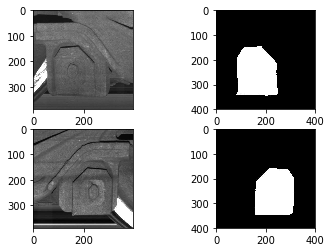

In [10]:
####display predice sample
fig = plt.figure()
file0 = files[0]
file1 = files[2]
plt.subplot(221)
plt.imshow(cv2.imread(os.path.join(test_imgs_path, file0)))
plt.subplot(222)
plt.imshow(cv2.imread(os.path.join(pred_path[0], file0)))
plt.subplot(223)
plt.imshow(cv2.imread(os.path.join(test_imgs_path, file1)))
plt.subplot(224)
plt.imshow(cv2.imread(os.path.join(pred_path[0], file1)))
plt.show()

In [11]:
import measurement as M

In [12]:
def get_contour(mask1):
#    kernel = np.ones((5,5), np.uint8)
#    mask1 = cv2.erode(mask1, kernel, iterations=1)
#    mask1 = cv2.dilate(mask1, kernel, iterations=1)
    
    mask1 = cv2.blur(mask1, (2,2))
    cv2.rectangle(mask1,(0,0),(mask1.shape[1],mask1.shape[0]), (0,0,0), 1)
    imgray = cv2.cvtColor(mask1,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(imgray,127,255,0)
    im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        for cnt in contours:
            area = 0
            if area < cv2.contourArea(cnt):
                cnt2 = cnt
    return cnt2

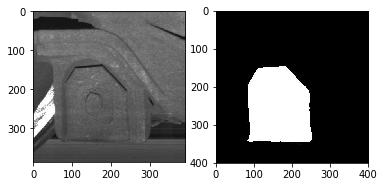

In [21]:
image = cv2.imread(os.path.join(test_imgs_path, file0))
mask = cv2.imread(os.path.join(pred_path[0], file0))


In [14]:
cnt = M.get_contour(mask)

In [15]:
angle = M.get_angle(cnt)

In [17]:
width, height = M.height_weight(cnt,a = 1)

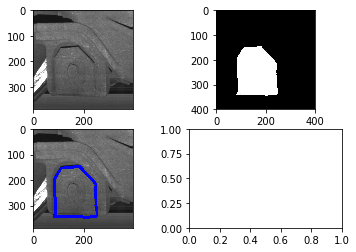

In [26]:
plt.subplot(221)
plt.imshow(cv2.imread(os.path.join(test_imgs_path, file0)))
plt.subplot(222)
plt.imshow(cv2.imread(os.path.join(pred_path[0], file0)))

cv2.drawContours(image, [cnt], -1, (0, 0, 255), 10)
plt.subplot(223)

plt.imshow(image)
plt.subplot(224)
plt.show()

In [19]:
print('angle, height, weight:',angle, height, width)

angle, height, weight: -89.60486602783203 200 167
